## Data cleaning

### Connection to database

In [2]:
%load_ext sql
%config SqlMagic.autopandas = True
# connect to local DuckDB database
%sql duckdb://:@/ecommerce_store.duckdb

Let's read the sample from dataset:

In [5]:
%%sql
select *
from user_event
using sample 5

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-15 15:56:40,view,3801058,2053013566176363511,appliances.iron,tefal,180.14,571904985,bc702c49-db20-4729-a992-5778bef24cc6
1,2019-11-24 05:34:32,view,31000205,2055156924315337497,undefined,deeper,149.24,516244038,701bc128-1c3d-4dba-b43d-4bdd1a0f83d6
2,2019-11-18 12:12:59,view,1306359,2053013558920217191,computers.notebook,acer,669.23,570593647,5c10a8ee-1156-4755-9b01-dd0efd0534a8
3,2019-11-15 09:19:10,view,9600012,2053013561185141473,undefined,dji,900.67,521647845,80379322-82ee-4151-858c-46e0f2e60a2e
4,2019-11-26 06:37:01,view,13200140,2053013557192163841,furniture.bedroom.bed,undefined,346.47,533994244,d9d0fdce-bd33-4784-ae64-5ef43e482b68


### Missing values imputation

In [8]:
%%sql
select count(case when event_time is null then 1 end)     as event_time_null_cnt,
       count(case when product_id is null then 1 end)     as product_id_null_cnt,
       count(case when category_id is null then 1 end)    as category_id_null_cnt,
       count(case when category_code is null then 1 end)  as category_code_null_cnt,
       count(case when brand is null then 1 end)          as brand_null_cnt,
       count(case when price is null then 1 end)          as price_null_cnt,
       count(case when user_id is null then 1 end)        as user_id_null_cnt,
       count(case when user_session is null then 1 end) as user_session_null_cnt
from user_event


*  duckdb://:***@/ecommerce_store.duckdb
Done.


,event_time_null_cnt,product_id_null_cnt,category_id_null_cnt,category_code_null_cnt,brand_null_cnt,price_null_cnt,user_id_null_cnt,user_session_null_cnt
0,0,0,0,21898171,9218235,0,0,10


In [23]:
%%sql
select count(case when category_code is null then 1 end)::numeric / count(1)  as category_code_null_percent,
       count(case when brand is null then 1 end)::numeric / count(1)          as brand_null_percent,
from user_event


*  duckdb://:***@/ecommerce_store.duckdb
Done.


,category_code_null_percent,brand_null_percent
0,0.324408,0.136562


Let's start with input missing values for `category_code`. What means `NULL` here?

In [21]:
%%sql
select *
from (select * from user_event where category_code is null)
using sample 10;

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-15 14:28:18,view,15100350,2053013557024391671,None,None,334.37,541468225,1d5da9c4-d5ce-4759-8cad-4c91743503e8
1,2019-11-17 07:08:00,view,9300087,2053013554524586339,None,sony,282.56,565840505,cba71780-4c94-44e5-8d46-91e93c169b26
2,2019-11-26 07:25:47,cart,16500007,2053013556462354899,None,omron,62.52,520084673,7e0969fa-b944-4162-a37f-a4be363eb9bb
3,2019-11-22 11:05:28,view,17301162,2053013553853497655,None,None,65.10,523601608,690b579e-f4d1-4560-aa66-2d9047435dc9
4,2019-11-15 16:34:29,view,14400016,2053013558492398155,None,hoco,15.42,517100651,dba1453c-871e-411c-89b0-db440533b59a
5,2019-11-14 12:56:46,view,12700975,2053013553559896355,None,nokian,55.86,516496063,1692cb39-c40c-4cb7-8d2c-83b548745f5c
6,2019-11-22 15:06:49,view,26205167,2053013563693335403,None,diamondunion,118.15,526029194,f89826a2-c07c-45ed-a02a-e608a6fbe2be
7,2019-11-27 16:03:59,view,29501858,2071490004441367490,None,mutant,15.32,517954859,d1d4c2db-770e-4e32-b04a-6371bb300e31
8,2019-11-26 08:30:06,view,4100346,2053013561218695907,None,sony,315.56,513402319,6896023f-9dbc-44df-9970-372e1cda15b7
9,2019-11-16 14:11:32,view,17300406,2053013553853497655,None,None,126.74,513777672,22832636-f492-4a3a-96a6-f287ab985ffc


In [24]:
%%sql
select count(distinct category_id), count(distinct category_code)
from user_event
where category_code is not null

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,count(DISTINCT category_id),count(DISTINCT category_code)
0,275,129


In [28]:
%%sql
select category_code, count(distinct category_id) as category_id_cnt
from user_event
group by category_code
having count(distinct category_id) > 1
order by category_id_cnt desc

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,category_code,category_id_cnt
0,None,409
1,apparel.shoes,26
2,apparel.shoes.keds,8
3,apparel.costume,8
4,accessories.bag,7
5,apparel.shirt,6
6,sport.bicycle,6
7,apparel.shoes.sandals,5
8,apparel.trousers,5
9,appliances.environment.vacuum,4


In [31]:
%%sql
select category_id, count(distinct category_code) as category_code_cnt
from user_event
group by category_id
having count(distinct category_code) > 1
order by category_code_cnt desc

*  duckdb://:***@/ecommerce_store.duckdb
Done.


""


Conclusion:
- All items in the shop are categorized - have nonempty `category_id`
- Not all categories have a meaningful name. In this case, we can't know anything about this shopping item.
- Some categories can have the same name. I have several interpretaions:
    - Either the differences between these categories are not essential
    - It's, essentialy, the same category of goods, but category_id is different, because there are differences in other things (country of user, for example).

From now on, I will use `category_name` as identifier of category and `category_id` will be ignored. Empty category names will be replaces by `undefined`.

To inpute missing values, run script `missing_values_imputation.py`

-------------------

Let's inspect `NULL`s in column `user_session`. There are only 10 such rows:

In [4]:
%sql select * from user_event where user_session is null

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-09 15:32:27,cart,19700004,2053013559104766575,None,kabrita,37.77,539704497,None
1,2019-11-09 17:15:24,cart,1005083,2053013555631882655,electronics.smartphone,honor,566.27,568843390,None
2,2019-11-13 04:02:03,cart,4804008,2053013554658804075,electronics.audio.headphone,bluedio,97.81,570411102,None
3,2019-11-13 07:18:35,cart,1004767,2053013555631882655,electronics.smartphone,samsung,243.51,570878749,None
4,2019-11-23 12:53:50,cart,7600528,2053013552821698803,None,tp-link,16.73,575357602,None
5,2019-11-25 05:04:42,cart,1802104,2053013554415534427,electronics.video.tv,arg,360.09,573722572,None
6,2019-11-25 07:03:38,cart,21403753,2053013561579406073,electronics.clocks,None,181.47,576301354,None
7,2019-11-26 07:48:12,cart,4804718,2053013554658804075,electronics.audio.headphone,apple,334.58,576935861,None
8,2019-11-27 07:02:20,cart,12719553,2053013553559896355,None,None,55.60,577167045,None
9,2019-11-29 17:25:56,cart,1005116,2053013555631882655,electronics.smartphone,apple,1001.42,579123407,None


Let's look closer on the activity of one of the users. For example, user with `user_id = 539704497`:

In [5]:
%%sql
select *
from user_event
where user_id = 539704497
order by event_time;

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-09 15:32:06,view,19700004,2053013559104766575,None,kabrita,37.77,539704497,e82ecde4-5c22-49e6-84cc-d63def4ff7d3
1,2019-11-09 15:32:27,cart,19700004,2053013559104766575,None,kabrita,37.77,539704497,None
2,2019-11-09 15:32:32,view,19700004,2053013559104766575,None,kabrita,37.77,539704497,e1e253ec-b564-48a8-8ff5-4e86bacb49f3
3,2019-11-09 15:38:25,view,19700004,2053013559104766575,None,kabrita,37.77,539704497,e1e253ec-b564-48a8-8ff5-4e86bacb49f3
4,2019-11-09 15:38:34,cart,19700004,2053013559104766575,None,kabrita,37.77,539704497,e1e253ec-b564-48a8-8ff5-4e86bacb49f3
5,2019-11-09 15:38:44,view,19700004,2053013559104766575,None,kabrita,37.77,539704497,e1e253ec-b564-48a8-8ff5-4e86bacb49f3
6,2019-11-23 09:45:22,view,4300011,2053013552385491165,None,philips,118.38,539704497,7c37c229-d95e-4685-b634-b4427e1d331e
7,2019-11-23 09:46:41,view,4300011,2053013552385491165,None,philips,118.38,539704497,7c37c229-d95e-4685-b634-b4427e1d331e
8,2019-11-23 09:46:50,view,4300011,2053013552385491165,None,philips,118.38,539704497,7c37c229-d95e-4685-b634-b4427e1d331e
9,2019-11-23 09:47:00,view,4300011,2053013552385491165,None,philips,118.38,539704497,7c37c229-d95e-4685-b634-b4427e1d331e


We can see that action with empty `user_session` happened 21 seconds after last event from previous session and 5 seconds befor event from next session. Clearly, we can just assume that this event happened in previous session. The short duration between sessions can be explained by different technical issues, for example - fail in statistics saving.

Let's check if the same pattern is valid for all users with empty session:

In [6]:
%%sql
create temp table user_with_empty_session
as
select *
from user_event
    join (select distinct user_id
            from user_event
            where user_session is null) as users
    using (user_id)

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,Count
0,182


Let's input missing values in `user_session` by closest `user_session` value, if there were some actions in 30 minute period before or after. Otherwise, let's generate a new ID of session using function `hash()`.


**To perform Missing Values Imputation, run script `missing_values_imputation.py`**

Let's check whether imputation was successful:

In [4]:
%%sql
select count(case when category_code is null then 1 end)  as category_code_null_cnt,
       count(case when brand is null then 1 end)          as brand_null_cnt,
       count(case when user_session is null then 1 end) as user_session_null_cnt
from user_event


*  duckdb://:***@/ecommerce_store.duckdb
Done.


,category_code_null_cnt,brand_null_cnt,user_session_null_cnt
0,0,0,0


✔️All is clear! There are not NULLs in the dataset anymore.

### Anomaly detection

We will identify anomaly users by the following variables:
1. Total money spent per user.
2. Total number of actions per user.
    - number of purchases
    - number of other actions

In [10]:
anomaly_users = []

### Anomaly users by total Revenue

In [7]:
%%sql df_user_revenue <<
select user_id,
       sum(case when event_type = 'purchase' then price else 0 end) as revenue
from user_event
group by user_id

*  duckdb://:***@/ecommerce_store.duckdb
Done.


In [8]:
df_user_revenue.describe(percentiles=[.01, .05, .10, .25, .50, .75, .90, .95, .99]).style.format({'revenue': '{:.0f}'})

,user_id,revenue
count,3696117.000000,3696117
mean,547804028.746647,74
std,24264189.004575,603
min,10300217.000000,0
1%,512429890.400000,0
5%,513431768.600000,0
10%,515096661.000000,0
25%,523678680.000000,0
50%,552003781.000000,0
75%,569815959.000000,0


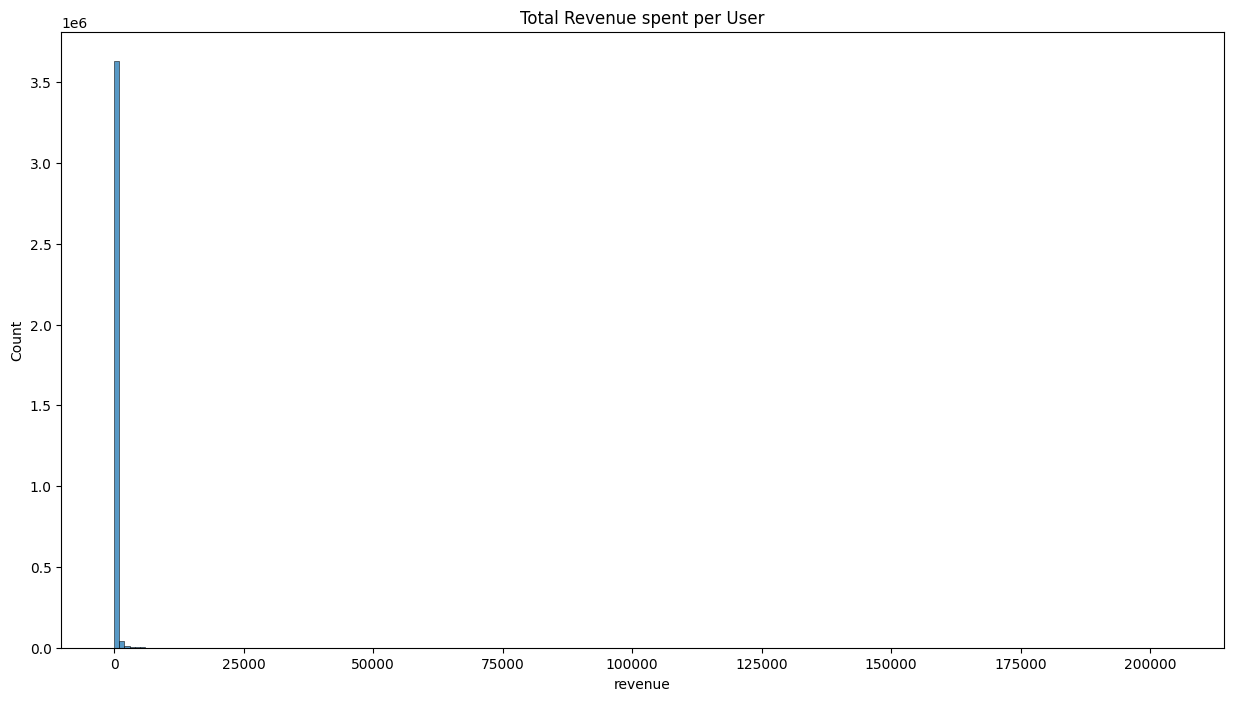

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 8))
sns.histplot(df_user_revenue, x='revenue', binwidth=1000)
plt.title('Total Revenue spent per User');


Text(0.5, 1.0, 'Total Revenue spent per User (caped by 99%-th percentile)')

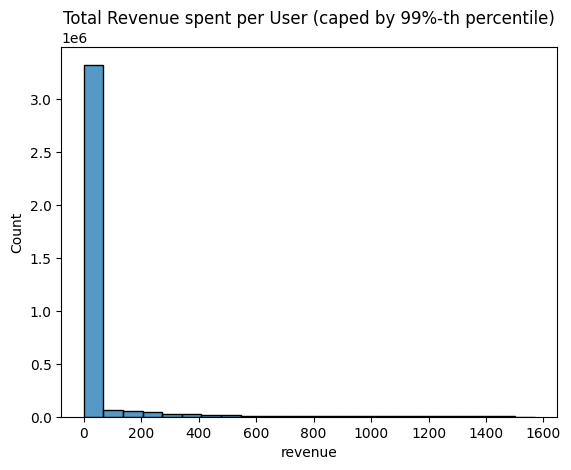

In [11]:
percentile_99 = np.percentile(df_user_revenue['revenue'].values, 99)
# print(percentile_99)
sns.histplot(df_user_revenue[df_user_revenue['revenue'] < percentile_99], x='revenue')
plt.title('Total Revenue spent per User (caped by 99%-th percentile)')

We see that the distribution of Revenue by User is smooth and monotone. Under 99%-th percentile there are no anomalies.

For the further analysis, it would be the best to divide users on segments based on their total Revenue spend. Because small group of users with high Revenue has greatly influence global distributional statistics. 

Let's look at the users, that lie beyond 99%-th percentile, that is, have Revenue > $62k. Let's call them "whales" 🐋

In [12]:
df_whales = df_user_revenue[df_user_revenue['revenue'] > percentile_99]
df_whales[['revenue']].describe().style.format({'revenue': '{:.0f}'})

,revenue
count,36962
mean,3667
std,4562
min,1570
25%,1879
50%,2479
75%,3773
max,203986


Text(0.5, 1.0, 'Whales: top users by Revenue')

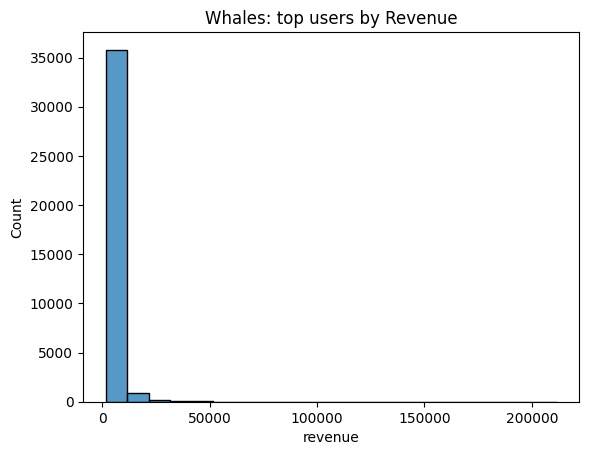

In [13]:
sns.histplot(x=df_whales['revenue'], binwidth=10000)
plt.title('Whales: top users by Revenue')

Even in this category of users there are outstanding exceptions. Let's look at users with more than $50K revenue.

,revenue
count,54
mean,75677
std,28650
min,50562
25%,54616
50%,69972
75%,83730
max,203986


<Axes: xlabel='revenue', ylabel='Count'>

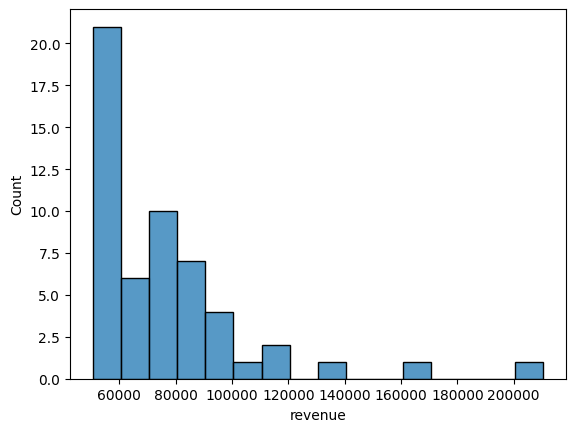

In [14]:
df_great_whales = df_whales[df_whales['revenue'] > 50000]
display(df_great_whales[['revenue']].describe().style.format({'revenue': '{:.0f}'}))
sns.histplot(x=df_whales.loc[df_whales['revenue'] > 50000, 'revenue'], binwidth=10000)


**Resolution**: don't exclude users (based on their Revenue).

I won't exclude these extremal users, because they seem to be naturally big customers. But for the further analysis we will keep in mind that some users have enormous Revenue.

### Anomaly detection: high activity, low number of purchases

In [2]:
%%sql df_user_actions <<
select user_id,
       count(case when event_type = 'purchase' then 1 end)   as purchase_cnt,
       count(case when event_type <> 'purchase' then 1 end)  as other_actions_cnt
from user_event
group by user_id

*  duckdb://:***@/ecommerce_store.duckdb
Done.


<Axes: xlabel='other_actions_cnt', ylabel='purchase_cnt'>

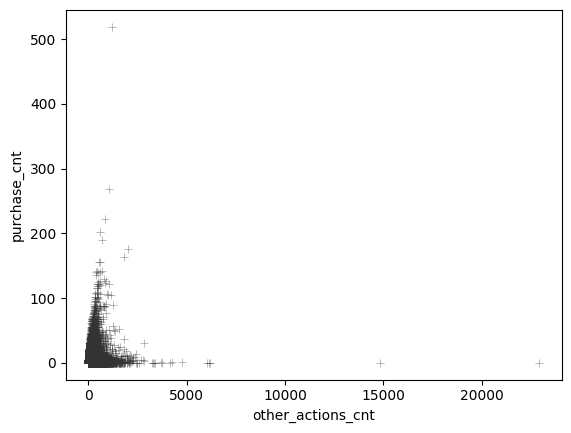

In [26]:
sns.scatterplot(data=df_user_actions, x='other_actions_cnt', y='purchase_cnt', color=".2", marker="+", alpha=0.5)


There are 2 anomaly users, who just surf the site without ever buying anithing, and user with very high conversion rate from view to purchase. Both cases are anomaly in user behavior and should be excluded.

In [11]:
anomaly_users += df_user_actions.sort_values(by='purchase_cnt', ascending=False).head(1)['user_id'].to_list()
anomaly_users += df_user_actions.sort_values(by='other_actions_cnt', ascending=False).head(2)['user_id'].to_list()

**Resolution**: remove 3 anomaly users with extremely high or low conversion to purchase.

To remove anomalies, execute script `anomaly_removal.py`.

In [12]:
print('Anomaly to be removed: ', *anomaly_users)

Anomaly to be removed:  564068124 568778435 569335945


Check if anomalies were indeed removed successfully:


In [3]:
%sql select * from user_event where user_id in (564068124, 568778435, 569335945)

*  duckdb://:***@/ecommerce_store.duckdb
Done.


""


✔️All is clear! There are no anomalies in the dataset anymore.

P.S. The old, initial dataset is stored in table `user_event_raw`.